# Exploring linear regression

In this noteboook we are going to play around with linear regression by first creating a sample data set and adding noise to it to simulate real data. We will then try to use linear regression to fit the data. Finally we'll evaluate the performance of the fit.

## Module imports

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform
from scipy import optimize
import random

In [31]:
def histogram_helper(X):
    # the histogram of the data
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    n, bins, patches = plt.hist(X, 50, normed=1, facecolor='green', alpha=0.75)
    plt.grid(True)
    plt.show()

## Data generation

Let's come up with a synthetic data set for our exploratory data analysis. We'll do this by sampling points from a uniform distribution between (0, 10,000)

In [32]:
# min and max for our independent variable
X_min = 0.0
X_max = 10000.0
# number of data points in the data set
N = 4000
X = uniform.rvs(loc=X_min, scale=X_max - X_min, size=N)

Now let's verify that the resulting distribution is indeed uniform

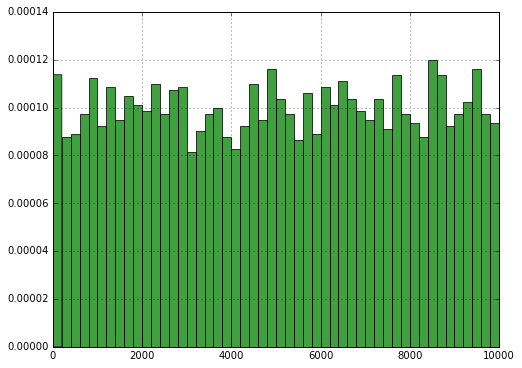

In [33]:
histogram_helper(X)

With this uniform distribution let's apply a function to the values and add some noise to 'simulate' realistic conditions

In [46]:
# Define a simple function F that is a cubic with roots at 4000, 6000
F = lambda x : ((x - 4000) ** 2.0)*(x - 6000)

# Add gaussian noise to the output with mean 0 and sigma 1
noise = lambda y : y + norm.rvs(loc=0, scale=1)

denoise = lambda y : y - norm.rvs(loc=0, scale=1)

X = np.sort(X)

Y = F(X)
Y_noise = noise(F(X))

We see that adding Gaussian noise to the distributions doesn't really change the shape

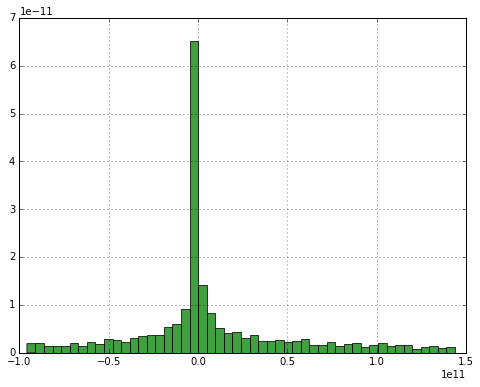

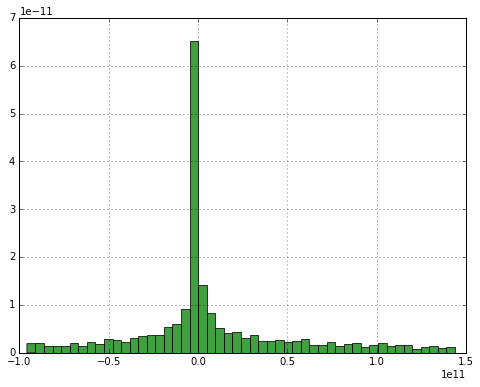

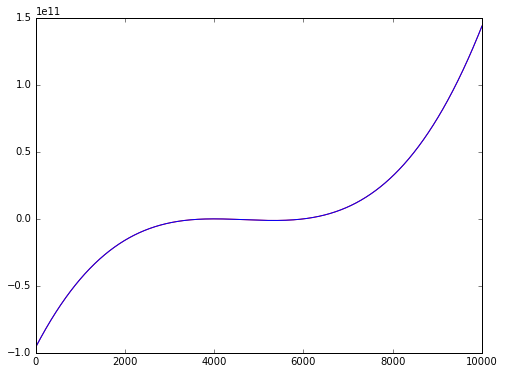

In [35]:
histogram_helper(Y)
histogram_helper(Y_noise)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X,Y,'r')
plt.plot(X,Y_noise,'b')
plt.show()

In [36]:
golden_ref = pd.DataFrame.from_dict({'X': X, 'Y': Y})
ref = pd.DataFrame.from_dict({'X': X, 'Y': Y_noise})

In [81]:
ref = ref.reset_index()
ref.columns = ['id', 'X', 'Y']

## Fitting noisy data

In [92]:
split = random.sample(ref.index, int(len(ref) * 0.4))
training = ref.ix[split]
test = ref.ix[~np.in1d(ref.index, split)]
test = test.sort_values(by='X').reset_index(drop=True)

training_split = random.sample(training.index, int(len(training) * 0.8))
validation = training.ix[~np.in1d(training.index, training_split)]
validation = validation.sort_values(by='X').reset_index()
training = training.ix[training_split]
training = training.sort_values(by='X').reset_index(drop=True)

In [93]:
training.head()

,id,X,Y
0,1,6.070800,-9.561198e+10
1,3,11.036825,-9.529535e+10
2,5,11.607517,-9.525900e+10
3,7,14.685923,-9.506312e+10
4,9,17.318904,-9.489578e+10


In [94]:
validation.head()

,index,id,X,Y
0,52,52,116.887222,-8.870890e+10
1,54,54,120.773548,-8.847294e+10
2,59,59,132.889586,-8.773995e+10
3,63,63,139.241130,-8.735730e+10
4,67,67,145.939422,-8.695495e+10


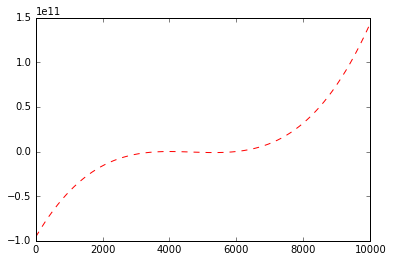

In [95]:
plt.plot(training['X'],training['Y'], 'r--')

In [88]:
fitted = np.polyfit(training['X'],training['Y'],3)
fitted_f = np.poly1d(fitted)

## Being realistic

In [96]:
training_error = np.sum(np.power(fitted_f(training['X']) - training['Y'], 2))
validation_error = np.sum(np.power(fitted_f(validation['X']) - validation['Y'],2))
test_error = np.sum(np.power(fitted_f(test['X']) - test['Y'],2))
true_error = np.sum(np.power(fitted_f(golden_ref['X']) - golden_ref['Y'],2))
print "Training error: %f" % training_error
print "Validation error: %f" % validation_error
print "Test error: %f" % test_error
print "True error: %f" % true_error

Training error: 0.000035
Validation error: 0.000009
Test error: 0.000068
True error: 1309.617489


From this it looks as though that the function is not fitting the empirical data well. However this is actually a relic of us adding noise to Y. If we try to fit on all the ref data we see that is the case

In [97]:
ref_fitted_func = np.poly1d(np.polyfit(ref['X'], ref['Y'],3))
ref_error = np.sum(np.power(golden_ref['Y'] - ref_fitted_func(golden_ref['X']),2))
print "Ref error: %f" % ref_error

Ref error: 1310.179808


In order to get a lower error score we would have to be able to model the distribution of the noise being added. Performing the inverse operation is not sufficient. Why? Imagine we have y' = y + f(x) where f(x) could be positive or negative. Doing y'' = y' - f(x) could just as easily add more noise!